# はじめに
LLMを実行するためのサンプルコードです。

### 概要
- perplexityでLLMを評価します。
- モデルはLlamaの小型モデルを使用します。

# 事前準備
1. Hugging Faceのアカウント作成
2. アクセストークンの作成  
Hugging Faceのアカウントにログインし、「自分のアイコン→Settings→Access Tokens→+ Create new token」からトークンを作成します。  
「Read access to contents of all public gated repos you can access」の権限が必要となります。  
3. Llamaの利用申請  
Hugging Faceで使用したいモデルのページにアクセスして、必要事項を記入して申請します。  
申請が承認されると利用可能になります。

# Perplexity
言語モデルの性能を評価する方法の1つです。  
次のトークンを予測する性能を測る指標になります。  
トークン列$X = [x_0, x_1, ..., x_t]$、パラメータ$\theta$の言語モデルに関するperplexityは下記の通り定義されます。  
$$
PPL(X) = \exp\{-\frac{1}{t}\sum_i^t \log p_{\theta}(x_i|x_{<i})\}
$$
ここで、$p(x_i|x_{<i})$はi番目より前のトークンを言語モデルに入力したときの、トークン$x_i$の生成確率です。  
expの中は各トークンのcross entropyの平均になっています。  
そこで、今回はAutoModelで計算されるlossを活用します。


# 実装
### 1. ライブラリのインポート

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
! pip install datasets
from datasets import load_dataset
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


GPU環境を確認します。  

In [2]:
!nvidia-smi

Sun Nov 10 06:13:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 2. 認証
Hugging Faceからモデルをダウンロードするために、アカウント認証を行います。  
login()を実行するとトークンを入力するUIが出てくるので、そこにトークンを入力します。  
また、colabのシークレットにトークンを保存しておけば、それを利用することもできます。

In [3]:
from huggingface_hub import login
# シークレットにトークンを保存しておけば下記で認証可能
from google.colab import userdata
login(token=userdata.get('HF_TOKEN'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### 3. 推論と評価
モデルとトークナイザーをダウンロードします。  
今回はLlama3.2の1Bモデルを使用します。



In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
)

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=False,
)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

データセットをダウンロードします。  
今回はメールのデータセットであるEnronを使用します。  
Pileというデータセットに含まれていますが、大規模なデータセットのため、Enronだけを抽出したものを用います。

In [5]:
dataset = load_dataset("suolyer/pile_enron", split='test')

# データセットの内容を確認
print(dataset)

# データセットからテキストの情報を取得
sentences = dataset['text']

# 最初の文の先頭を表示
print(sentences[0][:1000])

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

val.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/947 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1010 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'meta'],
    num_rows: 1010
})
pls print this email also.  thanks df
---------------------- Forwarded by Drew Fossum/ET&S/Enron on 03/20/2001 
04:37 PM ---------------------------
From: Michael P Moran/ENRON@enronXgate on 03/20/2001 02:08 PM
To: Rod Hayslett/ENRON@enronXgate
cc: Drew Fossum/ET&S/Enron@ENRON 

Subject: RE: ETS Approval Authorization Policy

I think one area that needs to be clarified is that many nonVPs believe that 
if they have the expenditure authority they can sign contracts in connection 
with the expenditure they are approving even in the absence of a power of 
attorney. I think we need the policy to clarify the difference between 
expenditure authority and execution authority. Our various company bylaws 
state that only VPs and above have authority to sign contracts and bind the 
company unless the President of the company delegates execution authority. 
Therefore we either need POAs or delegations of authority for execution 
auth

perplexityを計算します。  
そのために、入力と同じトークン列をラベルとして与えます。  
そうするとcross entropyを計算することができます。

In [6]:
# 推論時間を計測
%%time

loss_list = []
with torch.no_grad():
    # メモリが足りなくなるので、1サンプルずつ処理
    for i in range(len(sentences)):
        # メモリが足りなくなるので、長い文はスキップ
        if len(sentences[i]) > 10000:
            continue
        token_ids = tokenizer(sentences[i], return_tensors="pt").to(model.device)
        outputs = model(**token_ids, labels=token_ids["input_ids"])
        loss_list.append(outputs.loss.item())


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


CPU times: user 58.3 s, sys: 268 ms, total: 58.5 s
Wall time: 1min 2s


193.07748271234365


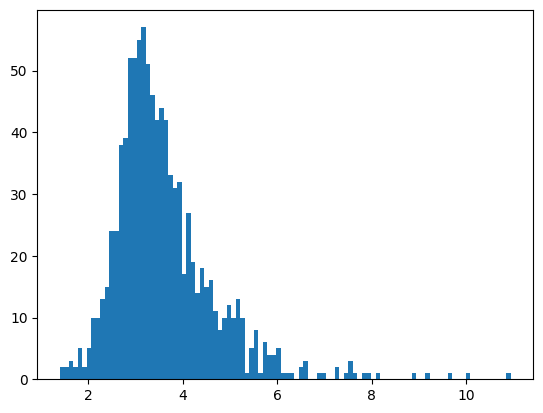

In [11]:
print(np.mean(np.exp(loss_list)))
plt.hist(loss_list, bins=100)
plt.show()

# おわりに
### 今回の結果
perplexityを計算することができました。  
lossの分布を確認すると、予測がうまくいっている文と、そうでない文があることが分かります。

### 次にやること  
LLMの性能を向上させる方法を試してみたいと思います。

### 参考資料  
- meta-llama/Llama-3.2-1B-Instruct  
https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct
- suolyer/pile_enron  
https://huggingface.co/datasets/suolyer/pile_enron
- GPT-2を使って文のパープレキシティを計算する  
https://gotutiyan.hatenablog.com/entry/2022/02/23/133414